In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time
import catboost as cb
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization#pip install bayesian-optimization
from sklearn.model_selection import KFold
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score,precision_recall_curve
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display
import gc

%matplotlib inline

Using TensorFlow backend.


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
df = reduce_mem_usage(pd.read_csv('train.csv'))
df_test = reduce_mem_usage(pd.read_csv('test.csv'))
#df = pd.read_csv('train.csv')
#df_test = pd.read_csv('test.csv')

Memory usage of dataframe is 267.04 MB
Memory usage after optimization is: 60.95 MB
Decreased by 77.2%
Memory usage of dataframe is 70.78 MB
Memory usage after optimization is: 16.49 MB
Decreased by 76.7%


In [24]:
#for time validation
#df = df.sort_values(by=['locdt'], ascending=True)
#print(df['locdt'])

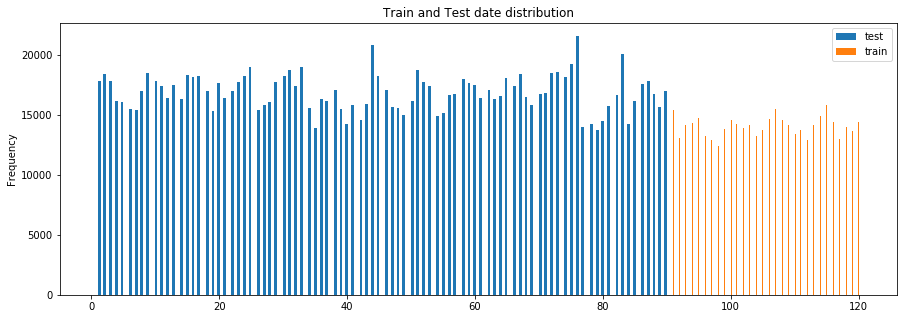

In [4]:
COL = 'locdt'
df[COL].plot(kind='hist', figsize=(15, 5), label='test', bins=200, title='Train and Test date distribution')
df_test[COL].plot(kind='hist', label='train', bins=200)
plt.legend()
plt.show()

In [8]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [9]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_FE'] = train_df[col].map(fq_encode)
            #print(train_df[col+'_FE'].sort_index().head())
            test_df[col+'_FE']  = test_df[col].map(fq_encode)
    return train_df, test_df
#encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])

In [6]:
# LABEL ENCODE
def encode_LE(cat_cols,train,test):
    for col in cat_cols:
        if col in train.columns:
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))      

In [7]:
cat_cols =  list(df.columns)
cat_cols.remove('fraud_ind')
cat_cols.remove('txkey')
cat_cols.remove('loctm')
cat_cols.remove('locdt')
cat_cols.remove('conam')
encode_LE(cat_cols,df,df_test)
df['flg_3dsmk'].value_counts(dropna=False, normalize=True).head()

0    0.949454
1    0.042279
2    0.008267
Name: flg_3dsmk, dtype: float64

In [63]:
print('No Frauds', round(df['fraud_ind'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['fraud_ind'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
df['fraud_ind'].value_counts()

No Frauds 98.66 % of the dataset
Frauds 1.34 % of the dataset


0    1501432
1      20355
Name: fraud_ind, dtype: int64

In [64]:
print('testdata =',df_test['txkey'].count())
print('1.34% of testdata =',round(df_test['txkey'].count()*0.0134))

testdata = 421665
1.34% of testdata = 5650.0


In [10]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1,df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df[nm].astype(str).values) + list(df_test[nm].astype(str).values))
    df[nm] = le.transform(list(df[nm].astype(str).values))
    df_test[nm] = le.transform(list(df_test[nm].astype(str).values))
    print(nm,', ',end='')
#encode_CB('stocn','scity',df,df_test)
#encode_CB('mcc','mchno',df,df_test)
#encode_CB('bacno','cano',df,df_test)
#encode_CB('scity','csmcu',df,df_test)
#encode_CB('etymd','csmcu',df,df_test)
#encode_CB('acqic','etymd',df,df_test)
#df['stocn_scity'].value_counts(dropna=False, normalize=True)

In [10]:
#nm_mean = by_group_col+'_'+groupby_col+'_mean'
#    nm_std = by_group_col+'_'+groupby_col+'_std'
#    df1[nm_mean] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
##    df1[nm_std] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')
#    df2[nm_mean] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
#    df2[nm_std] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')

In [11]:
# GROUP AGGREGATION MEAN AND STD
def group_ag(by_group_cols,groupby_cols,df1,df2,aggregations=['mean'],fillna=True):
    for bycol in by_group_cols:
        for groupcol in groupby_cols:
            for agg_type in aggregations:
                nm = by_group_col+'_'+groupby_col+agg_type
                temp_df = pd.concat([df1[[groupcol, bycol]], df2[[groupcol,bycol]]])
                temp_df = temp_df.groupby([groupcol])[bycol].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: nm})                
                temp_df.index = list(temp_df[groupcol])
                temp_df = temp_df[nm].to_dict()   

                df1[nm] = df1[groupcol].map(temp_df).astype('float32')
                df2[nm] = df2[groupcol].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[nm].fillna(-1,inplace=True)
                    test_df[nm].fillna(-1,inplace=True)    
                print("'"+nm+"'",', ',end='')
   
#group_ag(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'])

In [12]:
def encode_AG(main_columns, uids, train_df, test_df,aggregations=['mean'] ,
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
#encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

In [13]:
def change_time(data):
    time = data['loctm']
    hour = []
    minute = []
    second = []
    for i in time:        
        h = int(i/10000)
        m = int(i%10000/100)
        s = int(i%100)
        hour.append(h)
        minute.append(m)
        second.append(s)
    data['loctm_hour'] = hour
    data['loctm_min'] = minute
    data['loctm_s'] = second
#df['loctm'].value_counts().sort_index()

In [14]:
def money_process(data):
    log =[]
    sqrt =[]
    for i in data['conam']:
        if(i==0):
            sqrt.append(i)
            log.append(i) 
        else:
            l = np.log(i)
            s = np.sqrt(i)
            sqrt.append(s)
            log.append(l)
    data['conam_log'] = log
    #data['conam_sqrt'] = sqrt  
#money_process(df)
#money_process(df_test)
#print(df['conam_log'].head())

In [15]:
change_time(df)
change_time(df_test)
df.columns

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey',
       'loctm_hour', 'loctm_min', 'loctm_s'],
      dtype='object')

In [16]:
import copy
df_backup = copy.copy(df)
df_test_backup = copy.copy(df_test)

In [ ]:
#trainset的資料分布
from matplotlib import gridspec
plt.figure(figsize=(16,30*4))
gs = gridspec.GridSpec(df.shape[1], 1)#创建50行1列的画布
for i, col  in enumerate(df[df.columns]):    
    ax = plt.subplot(gs[i])
    sns.distplot(df[col][df["fraud_ind"] == 1],label = 'Is Fraud',bins=100)
    sns.distplot(df[col][df["fraud_ind"] == 0],label = 'Not Fraud',bins=100)
    plt.legend();
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(col))

In [222]:
for i,col in enumerate(df.columns):
    print(df[col].value_counts(dropna=False, normalize=False).sort_index())
    print("-------------------------------")

0       47940
1          10
2          34
3          30
4           2
5           5
6           1
8           3
9           1
10         14
11          3
12          2
13          5
15          3
16          1
17          8
18          9
19         10
20          6
21          6
22          8
23         83
24          6
25         17
26          3
27          7
28          1
29          1
30          1
31          1
        ...  
6832        2
6833        8
6834       90
6835        3
6836        1
6837        3
6838        1
6840        1
6841        4
6842       12
6843        3
6845       16
6846        5
6848        6
6849        5
6850        5
6851        1
6852        1
6853        4
6854        1
6855       29
6856        1
6857        8
6858        3
6859        1
6860       17
6861       11
6863        1
6864        1
6865        3
Name: acqic, Length: 6051, dtype: int64
-------------------------------
1         11
3          3
4          1
6         21
7         37
8        

Name: stscd, dtype: int64
-------------------------------
0          1
1          1
2          1
3          1
4          1
5          1
6          1
7          1
8          1
9          1
10         1
11         1
12         1
13         1
14         1
15         1
16         1
17         1
18         1
19         1
20         1
21         1
22         1
23         1
24         1
25         1
26         1
27         1
28         1
29         1
          ..
1958210    1
1958211    1
1958212    1
1958213    1
1958214    1
1958215    1
1958216    1
1958217    1
1958218    1
1958219    1
1958220    1
1958221    1
1958222    1
1958223    1
1958224    1
1958225    1
1958226    1
1958227    1
1958228    1
1958229    1
1958230    1
1958231    1
1958232    1
1958233    1
1958234    1
1958235    1
1958236    1
1958237    1
1958238    1
1958239    1
Name: txkey, Length: 1521787, dtype: int64
-------------------------------


In [125]:
a =['conam']
b =['insfg_iterm','bacno_cano','stocn_scity','ovrlt']
for i in range(len(a)): 
    for j in range(len(b)):
        #if(j>len(a)-1):
        #    break
        #if(i!=j):
           print(a[i],b[j])
   

conam insfg_iterm
conam bacno_cano
conam stocn_scity
conam ovrlt


In [ ]:
for i in range(0,len(b.columns)):
    for j in range(i+1,(len(b.columns)-1)):       
        if(i!=j):
            print(a[i],b[j])

In [146]:
a =['conam']
b = list(X_train.columns)
b.remove('conam')
b.remove('conam_log')

#b = df[a]
for i in range(len(a)):
    for j in range(len(b)):
#        if(i!=j):
            df = copy.copy(df_backup)
            df_test = copy.copy(df_test_backup)
            #print(df.columns)
    
            money_process(df)
            money_process(df_test)
            encode_CB('insfg','iterm',df,df_test)
            encode_CB('bacno','cano',df,df_test)
            encode_CB('stocn','scity',df,df_test)
            encode_CB('cano','contp',df,df_test)
            encode_CB('contp','scity',df,df_test)
            encode_CB('mcc','ovrlt',df,df_test)
            #encode_CB(a[i],a[j],df,df_test) 
            group_ag(a[i],b[j],df,df_test)
            
            model1_features =  list(df.columns)
            model1_features.remove('txkey')
            model1_features.remove('locdt')
            model1_features.remove('flbmk')
            #model1_features.remove('mcc')            
            model1_features.remove('insfg')
            model1_features.remove('iterm')
            model1_features.remove('fraud_ind')
            X_train = df[model1_features]
            Y_train = df['fraud_ind']
            X_test = df_test[model1_features]
            #print(X_train.columns)
            # TRAIN 75% PREDICT 25%
            idxT = df.index[:3*len(X_train)//4]
            idxV = df.index[3*len(X_train)//4:]
            model = xgb.XGBClassifier( 
                n_estimators=2000,
            max_depth=12, 
            learning_rate=0.02, 
            subsample=0.8,
            colsample_bytree=0.4, 
            missing=-1, 
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist' 
            # USE GPU
            tree_method='gpu_hist' 
            )

            history = model.fit(X_train.loc[idxT,model1_features], Y_train[idxT], 
                eval_set=[(X_train.loc[idxV,model1_features],Y_train[idxV])],
            verbose=0, early_stopping_rounds=100)

            pred = model.predict_proba(X_train.loc[idxV,model1_features])[:,1] 
            print( "  auc = ", roc_auc_score(Y_train[idxV], pred))
            threshold = 0.5
            y_pre = [int(item>threshold) for  item in pred]
            print( "  f1 = ", f1_score(Y_train[idxV], y_pre))
            #print( "  confusion_matrix = \r\n", confusion_matrix(Y_train[idxV],y_pre)) 

insfg_iterm , bacno_cano , stocn_scity , cano_contp , contp_scity , mcc_ovrlt , conam_acqic_mean , conam_acqic_std ,   auc =  0.9911174124801755
  f1 =  0.7498264290673454
insfg_iterm , bacno_cano , stocn_scity , cano_contp , contp_scity , mcc_ovrlt , conam_bacno_mean , conam_bacno_std ,   auc =  0.9914057535264182
  f1 =  0.7570751992607139
insfg_iterm , bacno_cano , stocn_scity , cano_contp , contp_scity , mcc_ovrlt , conam_cano_mean , conam_cano_std ,   auc =  0.9917083252911391
  f1 =  0.7553598331208714
insfg_iterm , bacno_cano , stocn_scity , cano_contp , contp_scity , mcc_ovrlt , conam_contp_mean , conam_contp_std ,   auc =  0.9911079595047767
  f1 =  0.7588505747126436
insfg_iterm , bacno_cano , stocn_scity , cano_contp , contp_scity , mcc_ovrlt , conam_csmcu_mean , conam_csmcu_std ,   auc =  0.9910161864161013
  f1 =  0.7451391314472
insfg_iterm , bacno_cano , stocn_scity , cano_contp , contp_scity , mcc_ovrlt , conam_ecfg_mean , conam_ecfg_std ,   auc =  0.9910883102847506
  

In [24]:
b = list(X_train.columns)
a= [b]
a

[['acqic',
  'bacno',
  'cano',
  'conam',
  'contp',
  'csmcu',
  'ecfg',
  'etymd',
  'flbmk',
  'flg_3dsmk',
  'hcefg',
  'insfg',
  'iterm',
  'loctm',
  'mcc',
  'mchno',
  'ovrlt',
  'scity',
  'stocn',
  'stscd']]

In [ ]:
b = list(X_train.columns)

for i in range(0,len(b)):
    for j in range(i+1,(len(b)-1)):       
        if(i!=j):
            df = copy.copy(df_backup)
            df_test = copy.copy(df_test_backup)
            #print(df.columns)
    
                       
            encode_CB(b[i],b[j],df,df_test)            
            
            model1_features =  list(df.columns)
            model1_features.remove('txkey')
            model1_features.remove('locdt')          
            model1_features.remove('fraud_ind')
            X_train = df[model1_features]
            Y_train = df['fraud_ind']
            X_test = df_test[model1_features]
            #print(X_train.columns)
            # TRAIN 75% PREDICT 25%
            idxT = df.index[:3*len(X_train)//4]
            idxV = df.index[3*len(X_train)//4:]
            model = xgb.XGBClassifier( 
                n_estimators=2000,
            max_depth=12, 
            learning_rate=0.02, 
            subsample=0.8,
            colsample_bytree=0.4, 
            missing=-1, 
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist' 
            # USE GPU
            tree_method='gpu_hist' 
            )

            history = model.fit(X_train.loc[idxT,model1_features], Y_train[idxT], 
                eval_set=[(X_train.loc[idxV,model1_features],Y_train[idxV])],
            verbose=0, early_stopping_rounds=200)

            pred = model.predict_proba(X_train.loc[idxV,model1_features])[:,1] 
            auc = roc_auc_score(Y_train[idxV], pred)
            threshold = 0.5
            y_pre = [int(item>threshold) for  item in pred]
            f1 = f1_score(Y_train[idxV], y_pre)
            if(auc >=0.9899):
                print( "  auc = ",auc ,', ',end='')
                print( "  f1 = ", f1)
            #print( "  confusion_matrix = \r\n", confusion_matrix(Y_train[idxV],y_pre)) 

acqic_bacno , acqic_cano , acqic_conam , acqic_contp , acqic_csmcu , acqic_ecfg , acqic_etymd , acqic_flbmk , acqic_flg_3dsmk , acqic_hcefg , acqic_insfg , acqic_iterm , acqic_mcc , acqic_mchno , acqic_ovrlt , acqic_scity , acqic_stocn , acqic_stscd , acqic_loctm_hour , acqic_loctm_min , bacno_cano ,   auc =  0.9902556707452981 ,   f1 =  0.7191575924374777
bacno_conam ,   auc =  0.9902766692929976 ,   f1 =  0.7171524128045866
bacno_contp ,   auc =  0.9903458423351289 ,   f1 =  0.7191575924374777
bacno_csmcu ,   auc =  0.9903098777462931 ,   f1 =  0.7164036346245817
bacno_ecfg ,   auc =  0.9902616632541232 ,   f1 =  0.717948717948718
bacno_etymd ,   auc =  0.9902446165359405 ,   f1 =  0.7138742198751801
bacno_flbmk ,   auc =  0.9902597150199186 ,   f1 =  0.7177216704559053
bacno_flg_3dsmk ,   auc =  0.9902259873906829 ,   f1 =  0.7201434548714883
bacno_hcefg ,   auc =  0.9902669064013487 ,   f1 =  0.7172430297953811
bacno_insfg ,   auc =  0.9901978348104344 ,   f1 =  0.7175992348158776


從這開始


In [17]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)
df.columns


Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey',
       'loctm_hour', 'loctm_min', 'loctm_s'],
      dtype='object')

In [19]:
# 获取最佳 阈值方法 
def get_threshold(pre,rec,threshold):
    thold = []
    for i in range(len(threshold)):
        if round(pre[i],4)== round(rec[i],4):
            thold.append(threshold[i]) 
    return thold
#pr,re,t = precision_recall_curve(Y_train,Y_valid)
#thold = get_threshold(pr,re,t)

In [ ]:
count_features =  list(df.columns)
#print(count_features)
count_features.remove('txkey')
count_features.remove('flbmk')
count_features.remove('flg_3dsmk')
count_features.remove('fraud_ind')
count_features.remove('conam')
count_features.remove('ecfg')
count_features.remove('insfg')
count_features.remove('locdt')
count_features.remove('loctm')
count_features.remove('ovrlt')
encode_FE(df,df_test,count_features)

In [88]:

#money_process(df)
#money_process(df_test)
#encode_CB('bacno','cano',df,df_test)
encode_CB('bacno','iterm',df,df_test)
#encode_CB('cano','stocn',df,df_test)

encode_CB('cano','ecfg',df,df_test)
encode_CB('etymd','insfg',df,df_test)
#encode_CB('flg_3dsmk','ovrlt',df,df_test)
#encode_CB('cano','csmcu',df,df_test)

#encode_CB('cano','insfg',df,df_test)


bacno_iterm , cano_ecfg , etymd_insfg , 

In [89]:
#group_ag('conam','stocn_scity',df,df_test)

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'mcc', 'mchno',
       'ovrlt', 'scity', 'stocn', 'stscd', 'loctm_hour', 'loctm_min',
       'loctm_s'],
      dtype='object')


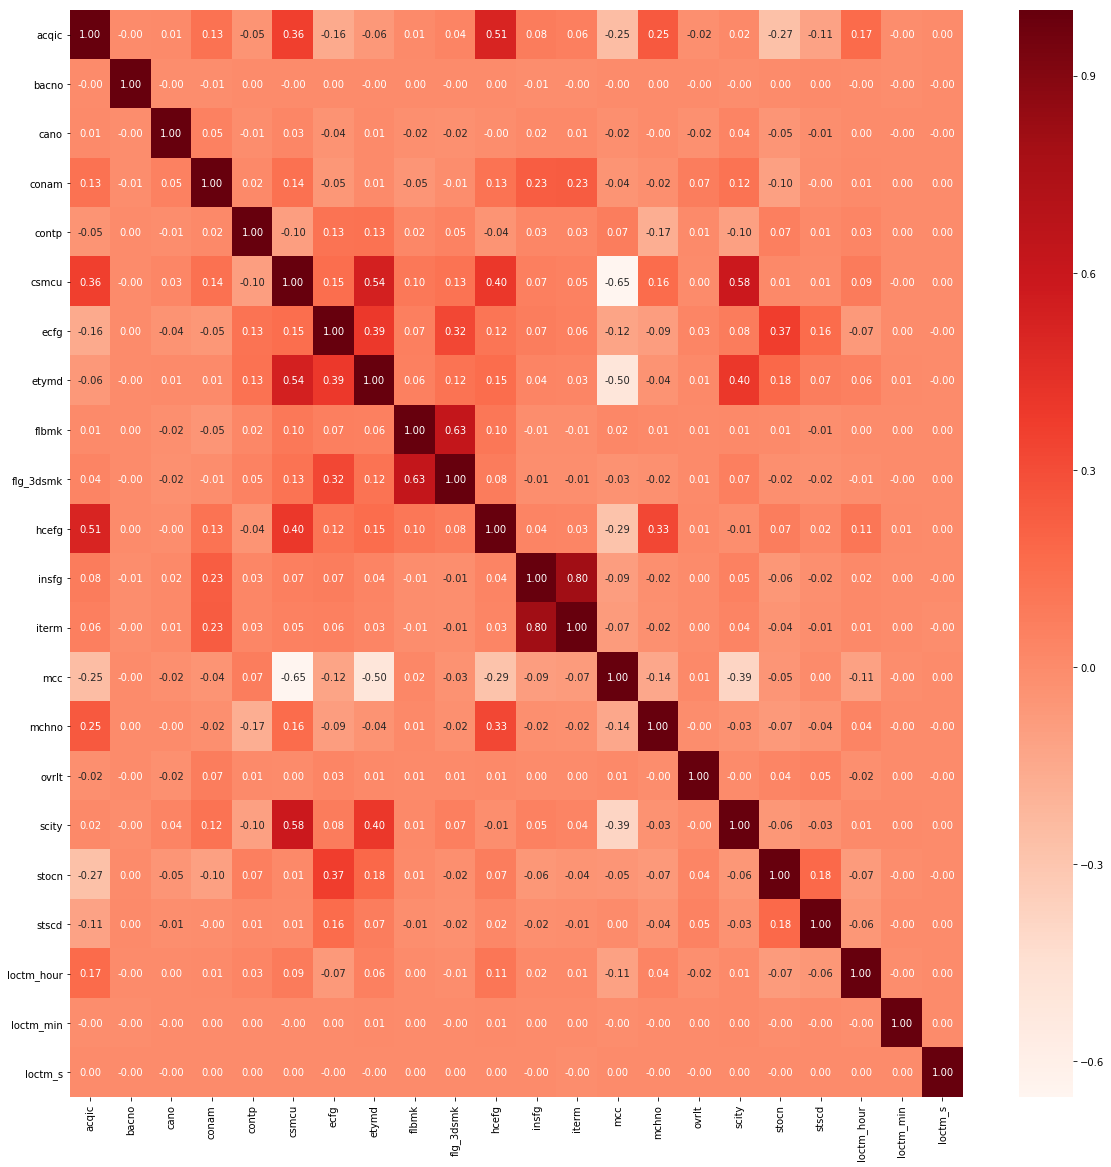

In [20]:
# 取出需要的特征
model1_features =  list(df.columns)
model1_features.remove('txkey')
model1_features.remove('locdt')
model1_features.remove('loctm')
#############################
#model1_features.remove('flbmk')
#model1_features.remove('mcc')
#model1_features.remove('insfg')
#model1_features.remove('iterm')
##########################################
model1_features.remove('fraud_ind')
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]
print(X_train.columns)
show_cor(X_train)

In [21]:
# TRAIN 75% PREDICT 25%
idxT = df.index[:3*len(X_train)//4]
idxV = df.index[3*len(X_train)//4:]

In [22]:
model = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02,        
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist' 
        # USE GPU
        tree_method='gpu_hist' 
    )

history = model.fit(X_train.loc[idxT,model1_features], Y_train[idxT], 
        eval_set=[(X_train.loc[idxV,model1_features],Y_train[idxV])],
        verbose=100, early_stopping_rounds=200)

pred = model.predict_proba(X_train.loc[idxV,model1_features])[:,1] 
print( "  auc = ", roc_auc_score(Y_train[idxV], pred))

pr,re,t = precision_recall_curve(Y_train[idxV],pred)
thold = get_threshold(pr,re,t)
threshold = 0.5
y_pre = [int(item>threshold) for  item in pred]
#y_pre_best = [int(item>thold) for  item in pred]
print( "  f1 = ", f1_score(Y_train[idxV], y_pre))
#print( "  f1_best = ", f1_score(Y_train[idxV], y_pre_best))
print( "  confusion_matrix = \r\n", confusion_matrix(Y_train[idxV],y_pre)) 

[0]	validation_0-auc:0.938187
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.978145
[200]	validation_0-auc:0.982441
[300]	validation_0-auc:0.984713
[400]	validation_0-auc:0.986569
[500]	validation_0-auc:0.987597
[600]	validation_0-auc:0.988275
[700]	validation_0-auc:0.98865
[800]	validation_0-auc:0.988963
[900]	validation_0-auc:0.989229
[1000]	validation_0-auc:0.989444
[1100]	validation_0-auc:0.989544
[1200]	validation_0-auc:0.989673
[1300]	validation_0-auc:0.989769
[1400]	validation_0-auc:0.989795
[1500]	validation_0-auc:0.989848
[1600]	validation_0-auc:0.98991
[1700]	validation_0-auc:0.98988
[1800]	validation_0-auc:0.989909
Stopping. Best iteration:
[1609]	validation_0-auc:0.989921

  auc =  0.9899212912427777
  f1 =  0.7044025157232704
  confusion_matrix = 
 [[375091    328]
 [  2116   2912]]


In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,model1_features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:500])
plt.title('Most Important Features')
plt.tight_layout()
plt.show()
del history; x=gc.collect()

In [75]:
perm = PermutationImportance(model, random_state=42).fit(X_train.loc[idxV,model1_features], Y_train[idxV])
eli5.show_weights(perm, feature_names = X_train.loc[idxV,model1_features].columns.tolist(),top=500)
  

Weight,Feature
0.0010 ± 0.0001,stocn
0.0010 ± 0.0000,stscd
0.0010 ± 0.0000,conam
0.0007 ± 0.0000,scity
0.0005 ± 0.0000,csmcu_FE
0.0005 ± 0.0000,stocn_FE
0.0004 ± 0.0000,stscd_FE
0.0004 ± 0.0001,cano_FE
0.0004 ± 0.0000,mchno_FE
0.0003 ± 0.0000,scity_FE


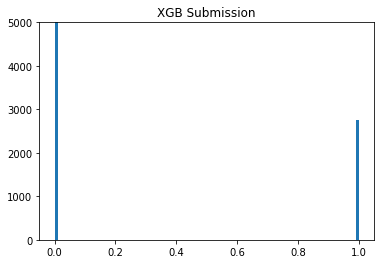

testdata = 421665
1.34% of testdata = 5650.0
fraud predict = 2758


In [41]:
# 结果保存
predictions = model.predict(X_test)
plt.hist(predictions,bins=100)
plt.ylim((0,5000))
plt.title('XGB Submission')
plt.show()
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = predictions
sampleSubmission.to_csv('submission_test.csv',index = None)

print('testdata =',df_test['txkey'].count())
print('1.34% of testdata =',round(df_test['txkey'].count()*0.0134))
print('fraud predict =',sampleSubmission['fraud_ind'].value_counts()[1])

In [ ]:
# # 删除只出现过1次的商店和只消费过1次的卡。
# data_new = data_df.groupby(['acqic','stocn','scity','mcc','mchno']).filter(lambda x: (len(x) > 1))
# data_new = data_new.groupby(['bacno','cano']).filter(lambda x: (len(x) > 1))
# data_new = data_new.reset_index()
# data_new.shape